# Data Analysis and Visualization of Time to Target with Tremor Identification

This code was developed to analyze data and generate figures for "Evaluating Mouse Control and Usability Patterns Across Tremor and Non-Tremor Populations"

### Loading necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Processing Functions

In [2]:
from scipy.signal import welch
from scipy.signal import detrend
from scipy.interpolate import interp1d
from scipy.signal import welch

# Estimate power spectral density using Welch’s method
# sampling rate can have minor variation
def computePSD(t, sig):

    # remove any offset
    sig = detrend(sig)

    # compute the average sampling frequency
    fs = len(t)/(t[-1]-t[0])
    fs = 1/0.015

    # Interpolate time and signal to estimate constant sampling rate
    interp_func = interp1d(t, sig, kind='linear', fill_value='extrapolate')
    sig = interp_func(np.arange(t[0], t[-1], 1/fs))

    # compute the power spectral density
    f, PSD = welch(sig, fs)
    
    return f, PSD

### Sample Data Set

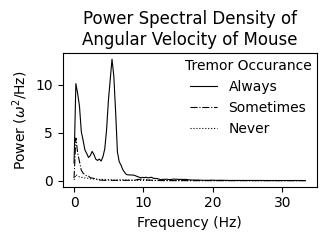

In [12]:
# participant reporting tremors always
A = pd.read_csv("./data/TestTaker44.csv")
A.columns = A.columns.str.strip()
# participant reporting tremors sometimes
S = pd.read_csv("./data/TestTaker42.csv")
S.columns = S.columns.str.strip()
# participant reporting not having tremors
N = pd.read_csv("./data/TestTaker1.csv")
N.columns =N.columns.str.strip()


tA = A["Timestamp"].values
ZA = A["GyroZ"].values

tS = S["Timestamp"].values
ZS= S["GyroZ"].values

tN = N["Timestamp"].values
ZN = N["GyroZ"].values

fA, PSDA = computePSD(tA, ZA)
fS, PSDS = computePSD(tS, ZS)
fN, PSDN = computePSD(tN, ZN)

# Plot the PSD
plt.figure(figsize=(3.5,2.5))

plt.plot(fA, PSDA, color='0', linewidth=.8, linestyle='-')
plt.plot(fS, PSDS, color='0', linewidth=.8, linestyle='-.')
plt.plot(fN, PSDN, color='0', linewidth=.8, linestyle=':')
# plt.legend(['Never', 'Sometimes', 'Always'])
plt.legend(
    ['Always', 'Sometimes', 'Never'],
    title='Tremor Occurance',
    loc='upper right',
    borderaxespad=0,
    frameon=False
)
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Power ($\omega^2$/Hz)')
plt.title('Power Spectral Density of\nAngular Velocity of Mouse', fontsize=12)
plt.tight_layout()
plt.savefig('PSD.png', dpi=300, bbox_inches='tight')

## Calculate Spectrums

In [13]:
# tremor status of participants
tremors = pd.read_csv('../survey analysis/survey_results_text.csv', skiprows=1, header=0)
tremors = tremors[tremors['participant_ID']!='SURVEY TEST']
tremors = tremors[['participant_ID', 'tremor_level']]

In [14]:
# Create dataframe with spectrum information
spectrum_power = pd.DataFrame({'participant_ID': [], 'power': []})

for i in range(50):
    if os.path.exists("./data/TestTaker" + str(i) + ".csv"):

        # Load the data
        data = pd.read_csv(("./data/TestTaker" + str(i) + ".csv"))
        data.columns = data.columns.str.strip()

        t = data["Timestamp"].values
        Z = data["GyroZ"].values

        # Calculate the normalized power spectral density
        f, PSD = computePSD(t, Z)

        # Identify [something]
        row = pd.DataFrame({'participant_ID': ['PT' + str(i).zfill(2)], 'power': [np.trapezoid(PSD, f)]})
       # print(row)
        spectrum_power = pd.concat([spectrum_power, row], ignore_index=True)

# Merge the data
participant_power = pd.merge(tremors, spectrum_power, on='participant_ID')

## Spectrum Power per Participant

### Combine Data Into One DataFrame

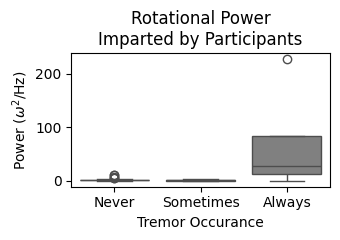

In [15]:
label_map = {
    'No': 'Never',
    'Sometimes': 'Sometimes',
    'Yes': 'Always'
}

# Create a new column with mapped labels
participant_power['tremor_label'] = participant_power['tremor_level'].map(label_map)

plt.figure(figsize=(3.5,2.5))

sns.boxplot(data=participant_power, x='tremor_label', y='power', color='grey')
plt.title('Rotational Power\nImparted by Participants', fontsize=12)
plt.xlabel('Tremor Occurance')
plt.ylabel(r'Power ($\omega^2$/Hz)')
plt.tight_layout()
plt.savefig('power.png', dpi=300, bbox_inches='tight')


In [36]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# One-way ANOVA: Score by tremor_level
anova_model = ols('power ~ C(tremor_level)', data=participant_power).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print(anova_table)


                       sum_sq    df          F    PR(>F)
C(tremor_level)  17164.266632   2.0  11.481311  0.000094
Residual         33636.924565  45.0        NaN       NaN


In [37]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Run Tukey’s test
tukey = pairwise_tukeyhsd(endog=participant_power['power'],
                          groups=participant_power['tremor_level'],
                          alpha=0.05)

# Print summary table
print(tukey.summary())

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1    group2  meandiff p-adj   lower    upper   reject
------------------------------------------------------------
       No Sometimes  -1.0165 0.9955 -28.3278  26.2947  False
       No       Yes  68.2452 0.0001  33.3692 103.1212   True
Sometimes       Yes  69.2617 0.0006  27.7297 110.7937   True
------------------------------------------------------------
